In [27]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score, f1_score, precision_score, recall_score
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
import warnings

# For parallel processing (-1 means use all cores, None means 1 core)
PARALLEL = -1

warnings.filterwarnings("ignore", category=UserWarning)
pd.options.mode.chained_assignment = None

# Load the data
train = pd.read_csv('../data/preprocessed/prp_combined_Y1.csv')
test = pd.read_csv('../data/preprocessed/prp_combined_Y2.csv')

## **Random Forests Classifier**
This notebook utilises a Random Forests Classifier to determine `DaysInHospital`. The problem is modelled as a classification task with 16 classes (0 - 15).
Hyperparameters are tested using Random Search (given the number of parameters, it would be infeasible to test using Grid Search), with the best estimator being selected via `roc_auc` score.
Stratified K-Fold is applied to preserve class distributions (important since dataset is imbalanced).

In [28]:
# Separate the data into features and target
Y_train = train['DaysInHospitalY2']
X_train = train.drop(columns=['DaysInHospitalY2', 'MemberID'])
Y_test = test['DaysInHospitalY3']
X_test = test.drop(columns=['DaysInHospitalY3', 'MemberID'])

In [30]:
# Definitions and parameter initializations

# K-Fold
outer_split = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
inner_split = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)

# Hyperparameters
param_grid = {
    'n_estimators': [25, 50, 100, 150],
    'max_depth': [5, 10, 15, 20],
    'min_samples_split': [2, 4, 8],
    'min_samples_leaf': [1, 2, 4, 8],
    'criterion': ['gini', 'entropy']
}

# Classifier
rfc = RandomForestClassifier()

# Scores
scoring = {
    'roc_auc': make_scorer(roc_auc_score),
    'f1': make_scorer(f1_score),
    'precision': make_scorer(precision_score),
    'recall': make_scorer(recall_score)
}

# Random Search for Parameters
rscv = RandomizedSearchCV(
    estimator=rfc, 
    param_distributions=param_grid, 
    n_iter=30, 
    cv=inner_split, 
    scoring=scoring, 
    refit='roc_auc', 
    n_jobs=PARALLEL, 
    verbose=4, 
    random_state=42
)

# Normalization scaler
scaler = MinMaxScaler()

cv_scores = {
    'roc_auc': [],
    'f1': [],
    'precision': [],
    'recall': []
}

best_estimators = []

In [31]:
# Primary cross validation loop
i = 1
for train_idx, test_idx in outer_split.split(X_train, Y_train):
    print(f"Loop {i}")
    i += 1

    X_train_outer, X_test_outer = X_train.iloc[train_idx], X_train.iloc[test_idx]
    Y_train_outer, Y_test_outer = Y_train.iloc[train_idx], Y_train.iloc[test_idx]

    # Normalize length of stay within CV loop
    X_train_outer['LengthOfStay'] = scaler.fit_transform(X_train_outer[['LengthOfStay']])
    X_test_outer['LengthOfStay'] = scaler.transform(X_test_outer[['LengthOfStay']])

    rscv.fit(X_train_outer, Y_train_outer)

    best_estimators.append(rscv.best_estimator_)
    
    Y_pred = rscv.best_estimator_.predict(X_test_outer)
    Y_pred_proba = rscv.best_estimator_.predict_proba(X_test_outer)

    # Calculate scores and save them
    roc_auc = roc_auc_score(Y_test_outer, Y_pred_proba, multi_class='ovr')
    precision = precision_score(Y_test_outer, Y_pred, average='macro', zero_division=1)
    recall = recall_score(Y_test_outer, Y_pred, average='macro', zero_division=1)
    f1 = f1_score(Y_test_outer, Y_pred, average='macro', zero_division=1)
    
    cv_scores['roc_auc'].append(roc_auc)
    cv_scores['f1'].append(f1)
    cv_scores['precision'].append(precision)
    cv_scores['recall'].append(precision)

Loop 1
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Loop 2
Fitting 2 folds for each of 30 candidates, totalling 60 fits
Loop 3
Fitting 2 folds for each of 30 candidates, totalling 60 fits


In [32]:
# Find the best estimator among best estimators using greatest roc_auc
hold_x_train, hold_x_test, hold_y_train, hold_y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

hold_x_train['LengthOfStay'] = scaler.fit_transform(hold_x_train[['LengthOfStay']])
hold_x_test['LengthOfStay'] = scaler.transform(hold_x_test[['LengthOfStay']])

best = {
    'best_roc_auc': 0,
    'best_estimator': None
}
for estimator in best_estimators:
    estimator.fit(hold_x_train, hold_y_train)

    pred = estimator.predict(hold_x_test)
    pred_proba = estimator.predict_proba(hold_x_test)

    roc_auc = roc_auc_score(hold_y_test, pred_proba, multi_class='ovr')
    
    if best['best_roc_auc'] < roc_auc:
        best['best_roc_auc'] = roc_auc
        best['best_estimator'] = estimator

{'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'entropy', 'max_depth': 10, 'max_features': 'sqrt', 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 4, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 25, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


In [33]:
# Evaluate performance of the best estimator

estimator = best['best_estimator']

estimator.fit(X_train, Y_train)

pred = estimator.predict(X_test)
pred_proba = estimator.predict_proba(X_test)

roc_auc = roc_auc_score(Y_test, pred_proba, multi_class='ovr')
precision = precision_score(Y_test, pred, average='macro', zero_division=1)
recall = recall_score(Y_test, pred, average='macro', zero_division=1)
f1 = f1_score(Y_test, pred, average='macro', zero_division=1)

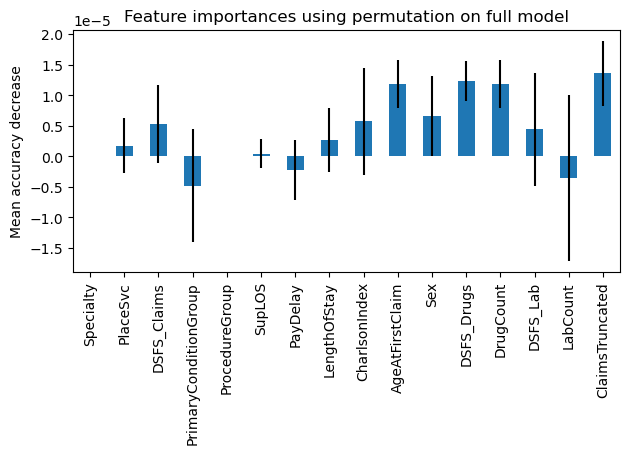

In [35]:
# Feature importance
from sklearn.inspection import permutation_importance
res = permutation_importance(estimator, X_train, Y_train, n_repeats=30, random_state=42, n_jobs=PARALLEL)

feature_importance = pd.Series(res.importances_mean, index=X_train.columns)

fig, ax = plt.subplots()
feature_importance.plot.bar(yerr=res.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

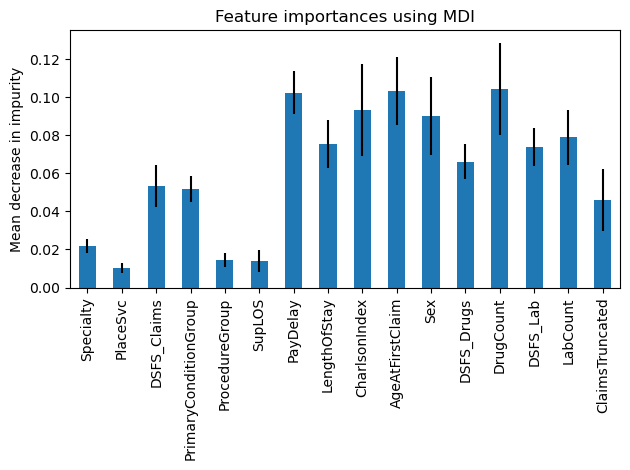

In [38]:
importances = estimator.feature_importances_
std = np.std([tree.feature_importances_ for tree in estimator.estimators_], axis=0)

feature_importance = pd.Series(importances, index=X_train.columns)

fig, ax = plt.subplots()
feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()